In [1]:
from gfn_environments.single_color_ramp import *
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import os
from gfn_environments.single_color_ramp import *


def screenshot_viewport_to_png(filepath: str, resolution_x: int = 800, resolution_y: int = 600):
    """
    Quick render of the scene from a default viewpoint (no camera setup needed).

    Args:
        filepath: Path where the PNG should be saved (e.g., "./output/screenshot.png")
        resolution_x: Width of the image in pixels
        resolution_y: Height of the image in pixels
    """
    # Ensure directory exists
    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    scene = bpy.context.scene

    # Store original settings
    original_camera = scene.camera
    original_engine = scene.render.engine

    # Create a temporary camera if none exists
    camera_data = bpy.data.cameras.new(name="TempCamera")
    camera_object = bpy.data.objects.new("TempCamera", camera_data)
    bpy.context.collection.objects.link(camera_object)

    # Position camera to view the mesh (adjust these values as needed)
    camera_object.location = (7, -7, 5)
    camera_object.rotation_euler = (1.1, 0, 0.785)

    # Set as active camera
    scene.camera = camera_object

    # Add lighting - Sun light for overall illumination
    sun_data = bpy.data.lights.new(name="TempSun", type='SUN')
    sun_data.energy = 3.0  # Brightness
    sun_object = bpy.data.objects.new("TempSun", sun_data)
    bpy.context.collection.objects.link(sun_object)
    sun_object.location = (5, 5, 10)
    sun_object.rotation_euler = (0.7, 0.3, 0)

    # Add fill light for better visibility
    fill_data = bpy.data.lights.new(name="TempFill", type='AREA')
    fill_data.energy = 100.0
    fill_data.size = 5.0
    fill_object = bpy.data.objects.new("TempFill", fill_data)
    bpy.context.collection.objects.link(fill_object)
    fill_object.location = (-5, -5, 8)
    fill_object.rotation_euler = (1.2, 0, -0.785)

    # Configure render settings for quick preview
    scene.render.engine = 'BLENDER_EEVEE_NEXT'  # Fast rendering (Blender 4.x)
    scene.render.image_settings.file_format = 'PNG'
    scene.render.filepath = filepath
    scene.render.resolution_x = resolution_x
    scene.render.resolution_y = resolution_y
    scene.render.resolution_percentage = 100

    # Quick render
    bpy.ops.render.render(write_still=True)

    # Cleanup: remove temporary objects
    bpy.data.objects.remove(camera_object, do_unlink=True)
    bpy.data.cameras.remove(camera_data)
    bpy.data.objects.remove(sun_object, do_unlink=True)
    bpy.data.lights.remove(sun_data)
    bpy.data.objects.remove(fill_object, do_unlink=True)
    bpy.data.lights.remove(fill_data)

    # Restore original settings
    scene.camera = original_camera
    scene.render.engine = original_engine

    print(f"Viewport screenshot saved to: {filepath}")


def test_trajectory_with_visual_grid():
    """
    Create a visual grid showing state tensor alongside Blender screenshots.
    """
    from blender_setup_utils import save_blend
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from matplotlib.patches import Rectangle

    print("\n" + "=" * 80)
    print("VISUAL TRAJECTORY GRID")
    print("=" * 80)

    # Setup Blender
    load_blend_single_color_ramp()
    blender_api = BlenderTerrainAPI()

    env = v2StepWEnv()
    max_steps = 10
    action_dim = env.n_actions

    # Define actions
    actions_to_take = [
        ('step_w', 2.0),
        ('step_scale', 0.1),
        ('add_color', 5),
        ('add_color', 12),
        ('add_color', 20),
        ('stop', 0),
    ]

    # Save initial state
    screenshot_viewport_to_png(filepath="./tests/file_dump/v2_step_0_initial.png")

    # Build state and save screenshots
    state = torch.zeros(max_steps, action_dim)
    screenshot_paths = ["./tests/file_dump/v2_step_0_initial.png"]
    color_slot_idx = 0

    for step_idx, (action_key, action_value) in enumerate(actions_to_take):
        # Convert action to one-hot
        action_one_hot = env.action_to_one_hot(action_key, action_value)
        flat_idx = torch.argmax(action_one_hot).item()
        state[step_idx] = action_one_hot

        # Execute action on Blender
        if action_key == 'add_color':
            env.execute_one_hot_action(blender_api, action_one_hot, slot_idx=color_slot_idx)
            color_slot_idx += 1
        elif action_key != 'stop':
            env.execute_one_hot_action(blender_api, action_one_hot)

        # Save screenshot
        screenshot_path = f"./tests/file_dump/v2_step_{step_idx+1}_{action_key}.png"
        screenshot_viewport_to_png(filepath=screenshot_path)
        screenshot_paths.append(screenshot_path)

    # Create visualization grid
    print("\nCreating visualization grid...")

    n_steps = len(actions_to_take) + 1  # +1 for initial state
    fig = plt.figure(figsize=(20, 3 * n_steps))

    for step_idx in range(n_steps):
        # Left column: Blender screenshot
        ax_img = plt.subplot(n_steps, 3, step_idx * 3 + 1)
        img = mpimg.imread(screenshot_paths[step_idx])
        ax_img.imshow(img)
        ax_img.axis('off')

        if step_idx == 0:
            ax_img.set_title('Initial State', fontsize=12, fontweight='bold')
        else:
            action_key, action_value = actions_to_take[step_idx - 1]
            ax_img.set_title(f'Step {step_idx}: {action_key}={action_value}',
                           fontsize=12, fontweight='bold')

        # Middle column: State tensor (action history up to this point)
        ax_state = plt.subplot(n_steps, 3, step_idx * 3 + 2)

        # Show state history up to this point
        state_history = state[:step_idx].clone() if step_idx > 0 else torch.zeros(1, action_dim)
        if step_idx == 0:
            state_history = torch.zeros(1, action_dim)

        # Create heatmap
        im = ax_state.imshow(state_history.numpy(), aspect='auto', cmap='Blues', vmin=0, vmax=1)
        ax_state.set_ylabel('Step', fontsize=10)
        ax_state.set_xlabel('Action Index', fontsize=10)
        ax_state.set_title(f'State Tensor\n(history up to step {step_idx})', fontsize=10)

        # Mark non-zero actions
        for hist_step in range(min(step_idx, max_steps)):
            action_idx = torch.argmax(state[hist_step]).item()
            if state[hist_step].sum() > 0:
                ax_state.add_patch(Rectangle((action_idx-0.5, hist_step-0.5), 1, 1,
                                            fill=False, edgecolor='red', linewidth=2))

        # Right column: Current action (one-hot)
        ax_action = plt.subplot(n_steps, 3, step_idx * 3 + 3)

        if step_idx > 0:
            current_action = state[step_idx - 1]
            action_idx = torch.argmax(current_action).item()
            action_def = env.tensor_to_action[action_idx]

            # Show one-hot vector as bar
            ax_action.bar(range(action_dim), current_action.numpy(), color='steelblue')
            ax_action.axvline(action_idx, color='red', linewidth=2, linestyle='--', label='Selected')
            ax_action.set_xlabel('Action Index', fontsize=10)
            ax_action.set_ylabel('Value', fontsize=10)
            ax_action.set_title(f'Action One-Hot\n[{action_idx}] {action_def.action_key}={action_def.value}',
                              fontsize=10)
            ax_action.set_ylim([0, 1.2])
            ax_action.legend()
        else:
            ax_action.text(0.5, 0.5, 'No action yet',
                         transform=ax_action.transAxes,
                         ha='center', va='center', fontsize=12)
            ax_action.axis('off')

    plt.tight_layout()
    output_path = "./tests/file_dump/trajectory_visualization.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\n📊 Saved visualization grid to: {output_path}")
    plt.close()

    print("\n" + "=" * 80)
    print("✅ Visualization complete!")
    print("=" * 80)


if __name__ == "__main__":
    test_trajectory_with_visual_grid()


VISUAL TRAJECTORY GRID
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Fra:1 Mem:55.37M (Peak 55.37M) | Time:00:00.28 | Rendering 1 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.32 | Rendering 25 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.35 | Rendering 50 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.37 | Rendering 64 / 64 samples
Saved: 'tests/file_dump/v2_step_0_initial.png'
Time: 00:00.42 (Saving: 00:00.05)

Viewport screenshot saved to: ./tests/file_dump/v2_step_0_initial.png
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.00 | Rendering 1 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.03 | Rendering 25 / 64 samples
Fra:1 Mem:55.38M (Peak


VISUAL TRAJECTORY GRID
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.00 | Rendering 1 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.03 | Rendering 25 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.06 | Rendering 50 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.07 | Rendering 64 / 64 samples
Saved: 'tests/file_dump/v2_step_0_initial.png'
Time: 00:00.09 (Saving: 00:00.01)

Viewport screenshot saved to: ./tests/file_dump/v2_step_0_initial.png
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.00 | Rendering 1 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.03 | Rendering 25 / 64 samples
Fra:1 Mem:55.38M (Peak

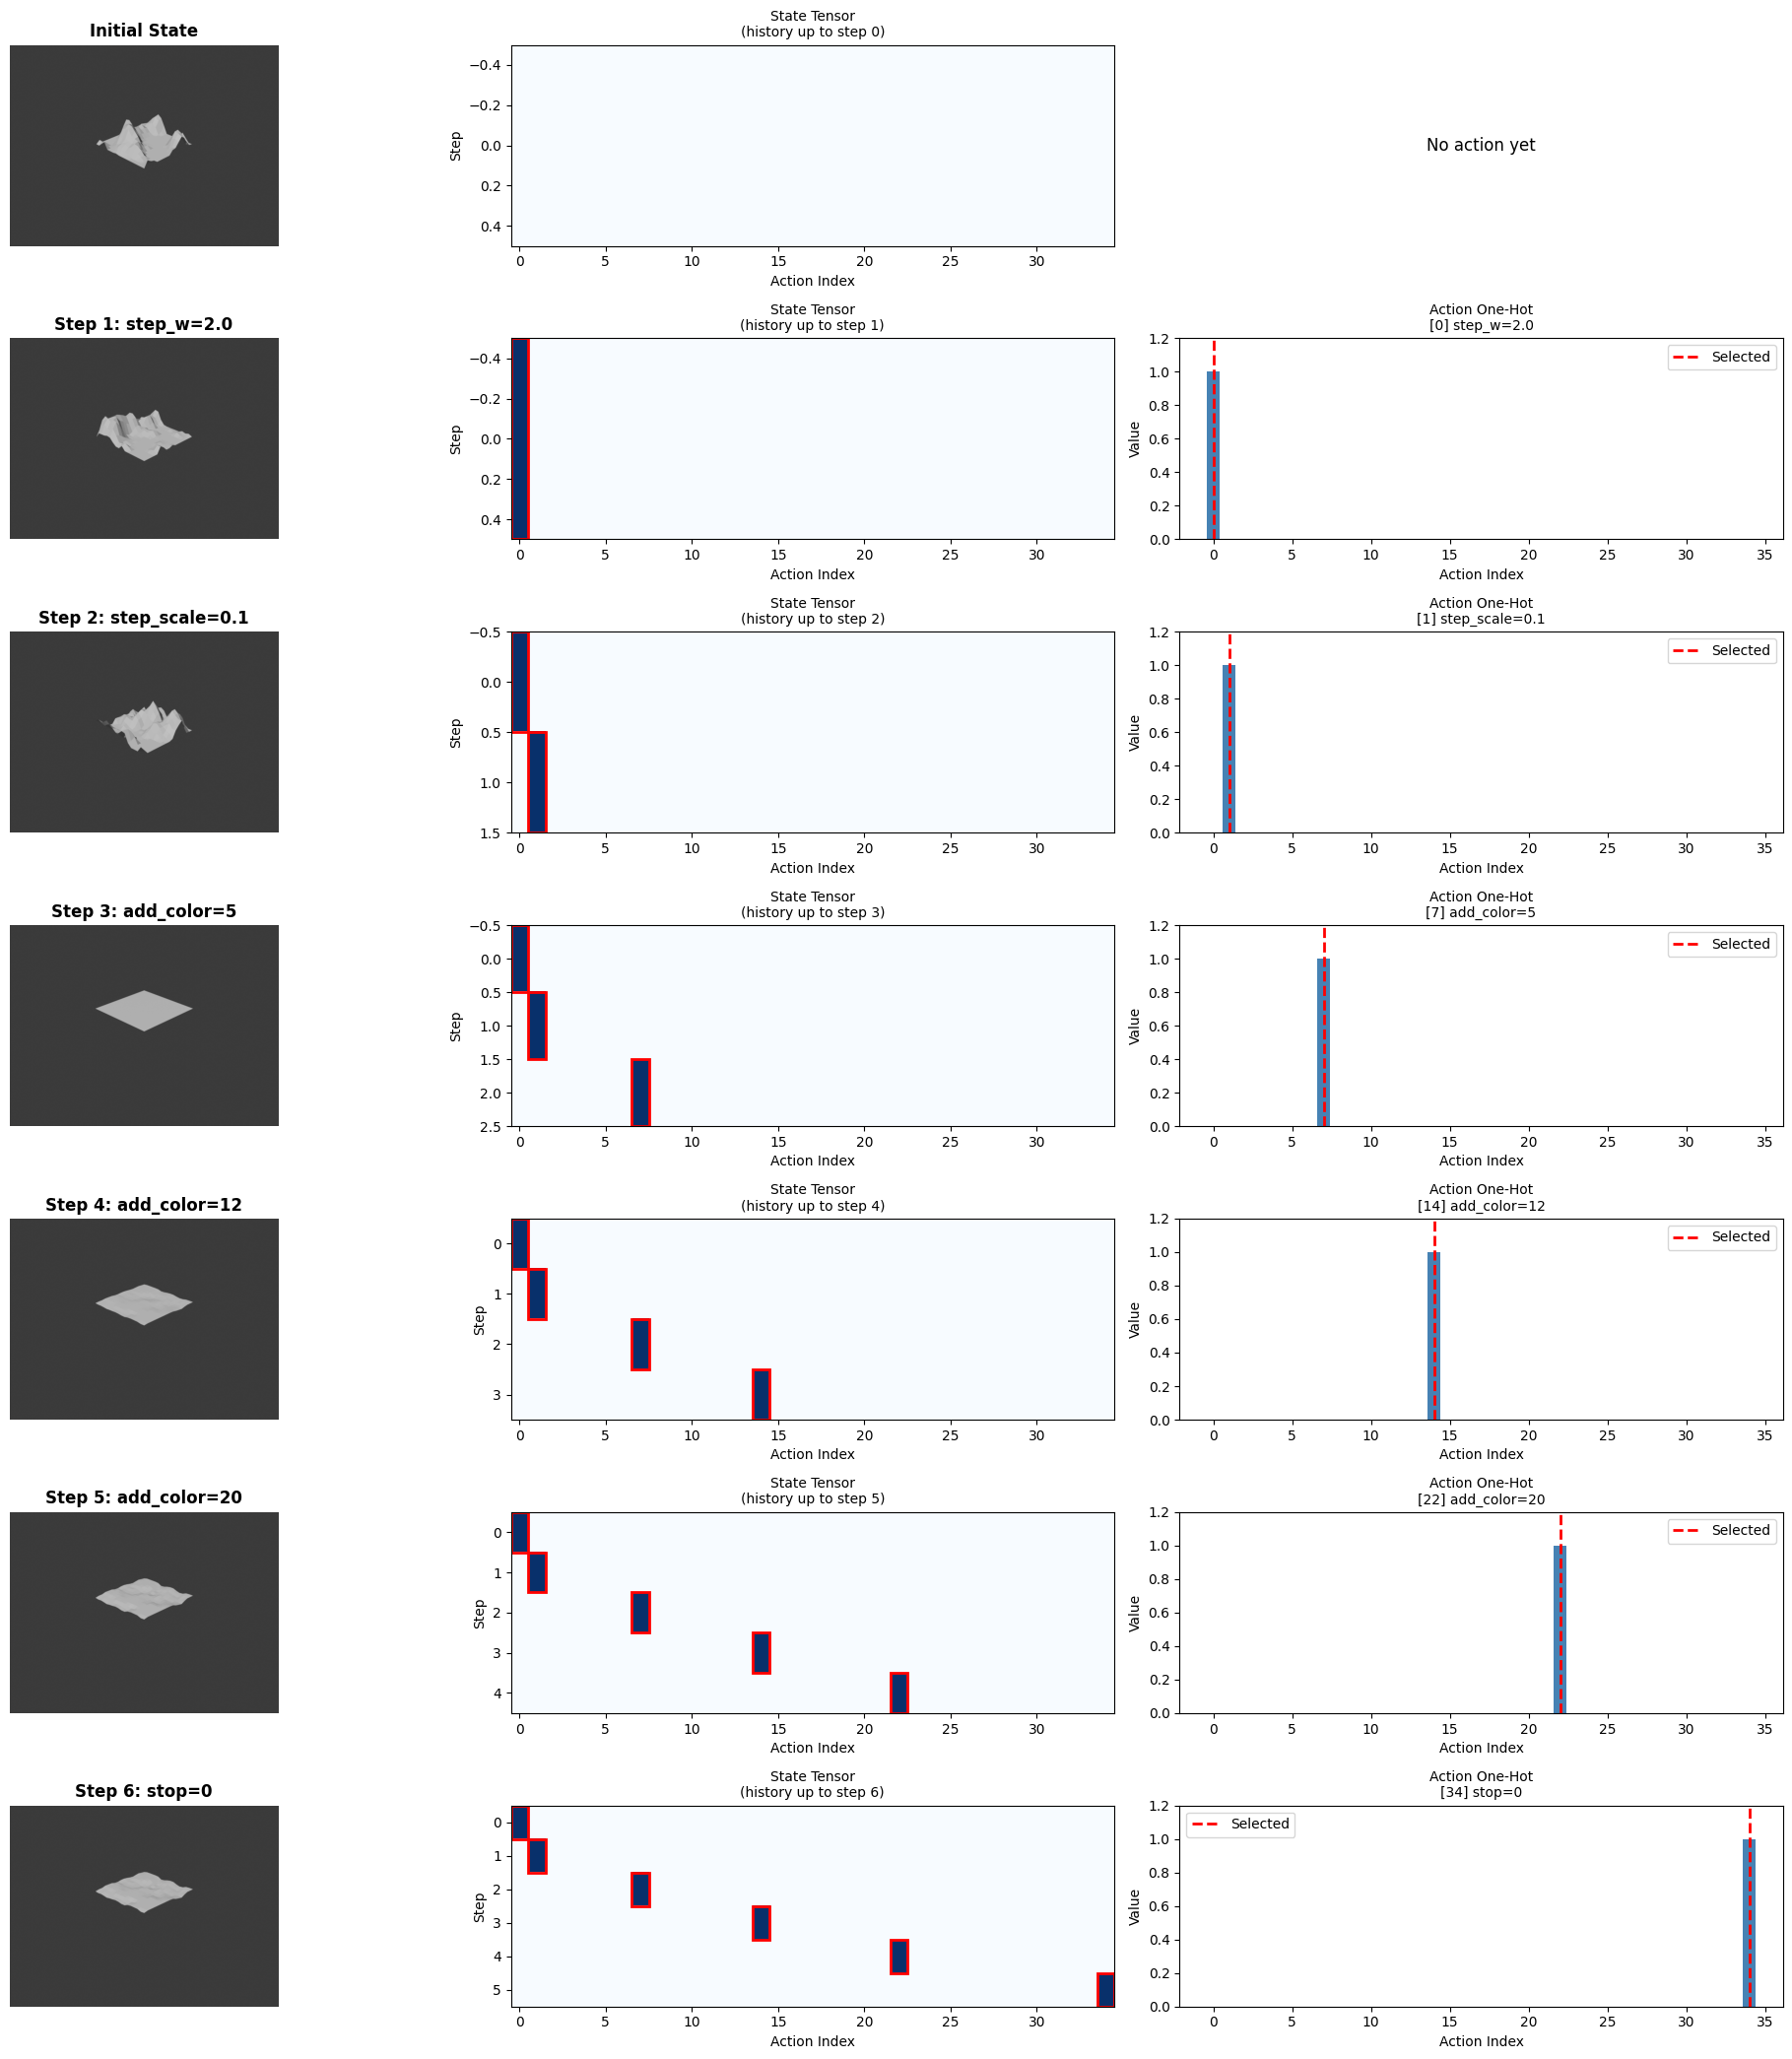


📊 Saved visualization grid to: ./tests/file_dump/trajectory_visualization.png

✅ Visualization complete!


In [2]:
def test_trajectory_with_visual_grid():
    """
    Create a visual grid showing state tensor alongside Blender screenshots.
    """
    from blender_setup_utils import save_blend
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from matplotlib.patches import Rectangle

    print("\n" + "=" * 80)
    print("VISUAL TRAJECTORY GRID")
    print("=" * 80)

    # Setup Blender
    load_blend_single_color_ramp()
    blender_api = BlenderTerrainAPI()

    env = v2StepWEnv()
    max_steps = 10
    action_dim = env.n_actions

    # Define actions
    actions_to_take = [
        ('step_w', 2.0),
        ('step_scale', 0.1),
        ('add_color', 5),
        ('add_color', 12),
        ('add_color', 20),
        ('stop', 0),
    ]

    # Save initial state
    screenshot_viewport_to_png(filepath="./tests/file_dump/v2_step_0_initial.png")

    # Build state and save screenshots
    state = torch.zeros(max_steps, action_dim)
    screenshot_paths = ["./tests/file_dump/v2_step_0_initial.png"]
    color_slot_idx = 0

    for step_idx, (action_key, action_value) in enumerate(actions_to_take):
        # Convert action to one-hot
        action_one_hot = env.action_to_one_hot(action_key, action_value)
        flat_idx = torch.argmax(action_one_hot).item()
        state[step_idx] = action_one_hot

        # Execute action on Blender
        if action_key == 'add_color':
            env.execute_one_hot_action(blender_api, action_one_hot, slot_idx=color_slot_idx)
            color_slot_idx += 1
        elif action_key != 'stop':
            env.execute_one_hot_action(blender_api, action_one_hot)

        # Save screenshot
        screenshot_path = f"./tests/file_dump/v2_step_{step_idx+1}_{action_key}.png"
        screenshot_viewport_to_png(filepath=screenshot_path)
        screenshot_paths.append(screenshot_path)

    # Create visualization grid
    print("\nCreating visualization grid...")

    n_steps = len(actions_to_take) + 1  # +1 for initial state
    fig = plt.figure(figsize=(20, 3 * n_steps))

    for step_idx in range(n_steps):
        # Left column: Blender screenshot
        ax_img = plt.subplot(n_steps, 3, step_idx * 3 + 1)
        img = mpimg.imread(screenshot_paths[step_idx])
        ax_img.imshow(img)
        ax_img.axis('off')

        if step_idx == 0:
            ax_img.set_title('Initial State', fontsize=12, fontweight='bold')
        else:
            action_key, action_value = actions_to_take[step_idx - 1]
            ax_img.set_title(f'Step {step_idx}: {action_key}={action_value}',
                           fontsize=12, fontweight='bold')

        # Middle column: State tensor (action history up to this point)
        ax_state = plt.subplot(n_steps, 3, step_idx * 3 + 2)

        # Show state history up to this point
        state_history = state[:step_idx].clone() if step_idx > 0 else torch.zeros(1, action_dim)
        if step_idx == 0:
            state_history = torch.zeros(1, action_dim)

        # Create heatmap
        im = ax_state.imshow(state_history.numpy(), aspect='auto', cmap='Blues', vmin=0, vmax=1)
        ax_state.set_ylabel('Step', fontsize=10)
        ax_state.set_xlabel('Action Index', fontsize=10)
        ax_state.set_title(f'State Tensor\n(history up to step {step_idx})', fontsize=10)

        # Mark non-zero actions
        for hist_step in range(min(step_idx, max_steps)):
            action_idx = torch.argmax(state[hist_step]).item()
            if state[hist_step].sum() > 0:
                ax_state.add_patch(Rectangle((action_idx-0.5, hist_step-0.5), 1, 1,
                                            fill=False, edgecolor='red', linewidth=2))

        # Right column: Current action (one-hot)
        ax_action = plt.subplot(n_steps, 3, step_idx * 3 + 3)

        if step_idx > 0:
            current_action = state[step_idx - 1]
            action_idx = torch.argmax(current_action).item()
            action_def = env.tensor_to_action[action_idx]

            # Show one-hot vector as bar
            ax_action.bar(range(action_dim), current_action.numpy(), color='steelblue')
            ax_action.axvline(action_idx, color='red', linewidth=2, linestyle='--', label='Selected')
            ax_action.set_xlabel('Action Index', fontsize=10)
            ax_action.set_ylabel('Value', fontsize=10)
            ax_action.set_title(f'Action One-Hot\n[{action_idx}] {action_def.action_key}={action_def.value}',
                              fontsize=10)
            ax_action.set_ylim([0, 1.2])
            ax_action.legend()
        else:
            ax_action.text(0.5, 0.5, 'No action yet',
                         transform=ax_action.transAxes,
                         ha='center', va='center', fontsize=12)
            ax_action.axis('off')

    plt.tight_layout()
    plt.show()  # Display in notebook

    # Also save it
    output_path = "./tests/file_dump/trajectory_visualization.png"
    fig.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\n📊 Saved visualization grid to: {output_path}")

    print("\n" + "=" * 80)
    print("✅ Visualization complete!")
    print("=" * 80)


if __name__ == "__main__":
    test_trajectory_with_visual_grid()


VISUAL TRAJECTORY GRID
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.00 | Rendering 1 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.03 | Rendering 25 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.06 | Rendering 50 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.07 | Rendering 64 / 64 samples
Saved: 'tests/file_dump/v2_step_0_initial.png'
Time: 00:00.09 (Saving: 00:00.01)

Viewport screenshot saved to: ./tests/file_dump/v2_step_0_initial.png
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.00 | Rendering 1 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.04 | Rendering 25 / 64 samples
Fra:1 Mem:55.38M (Peak

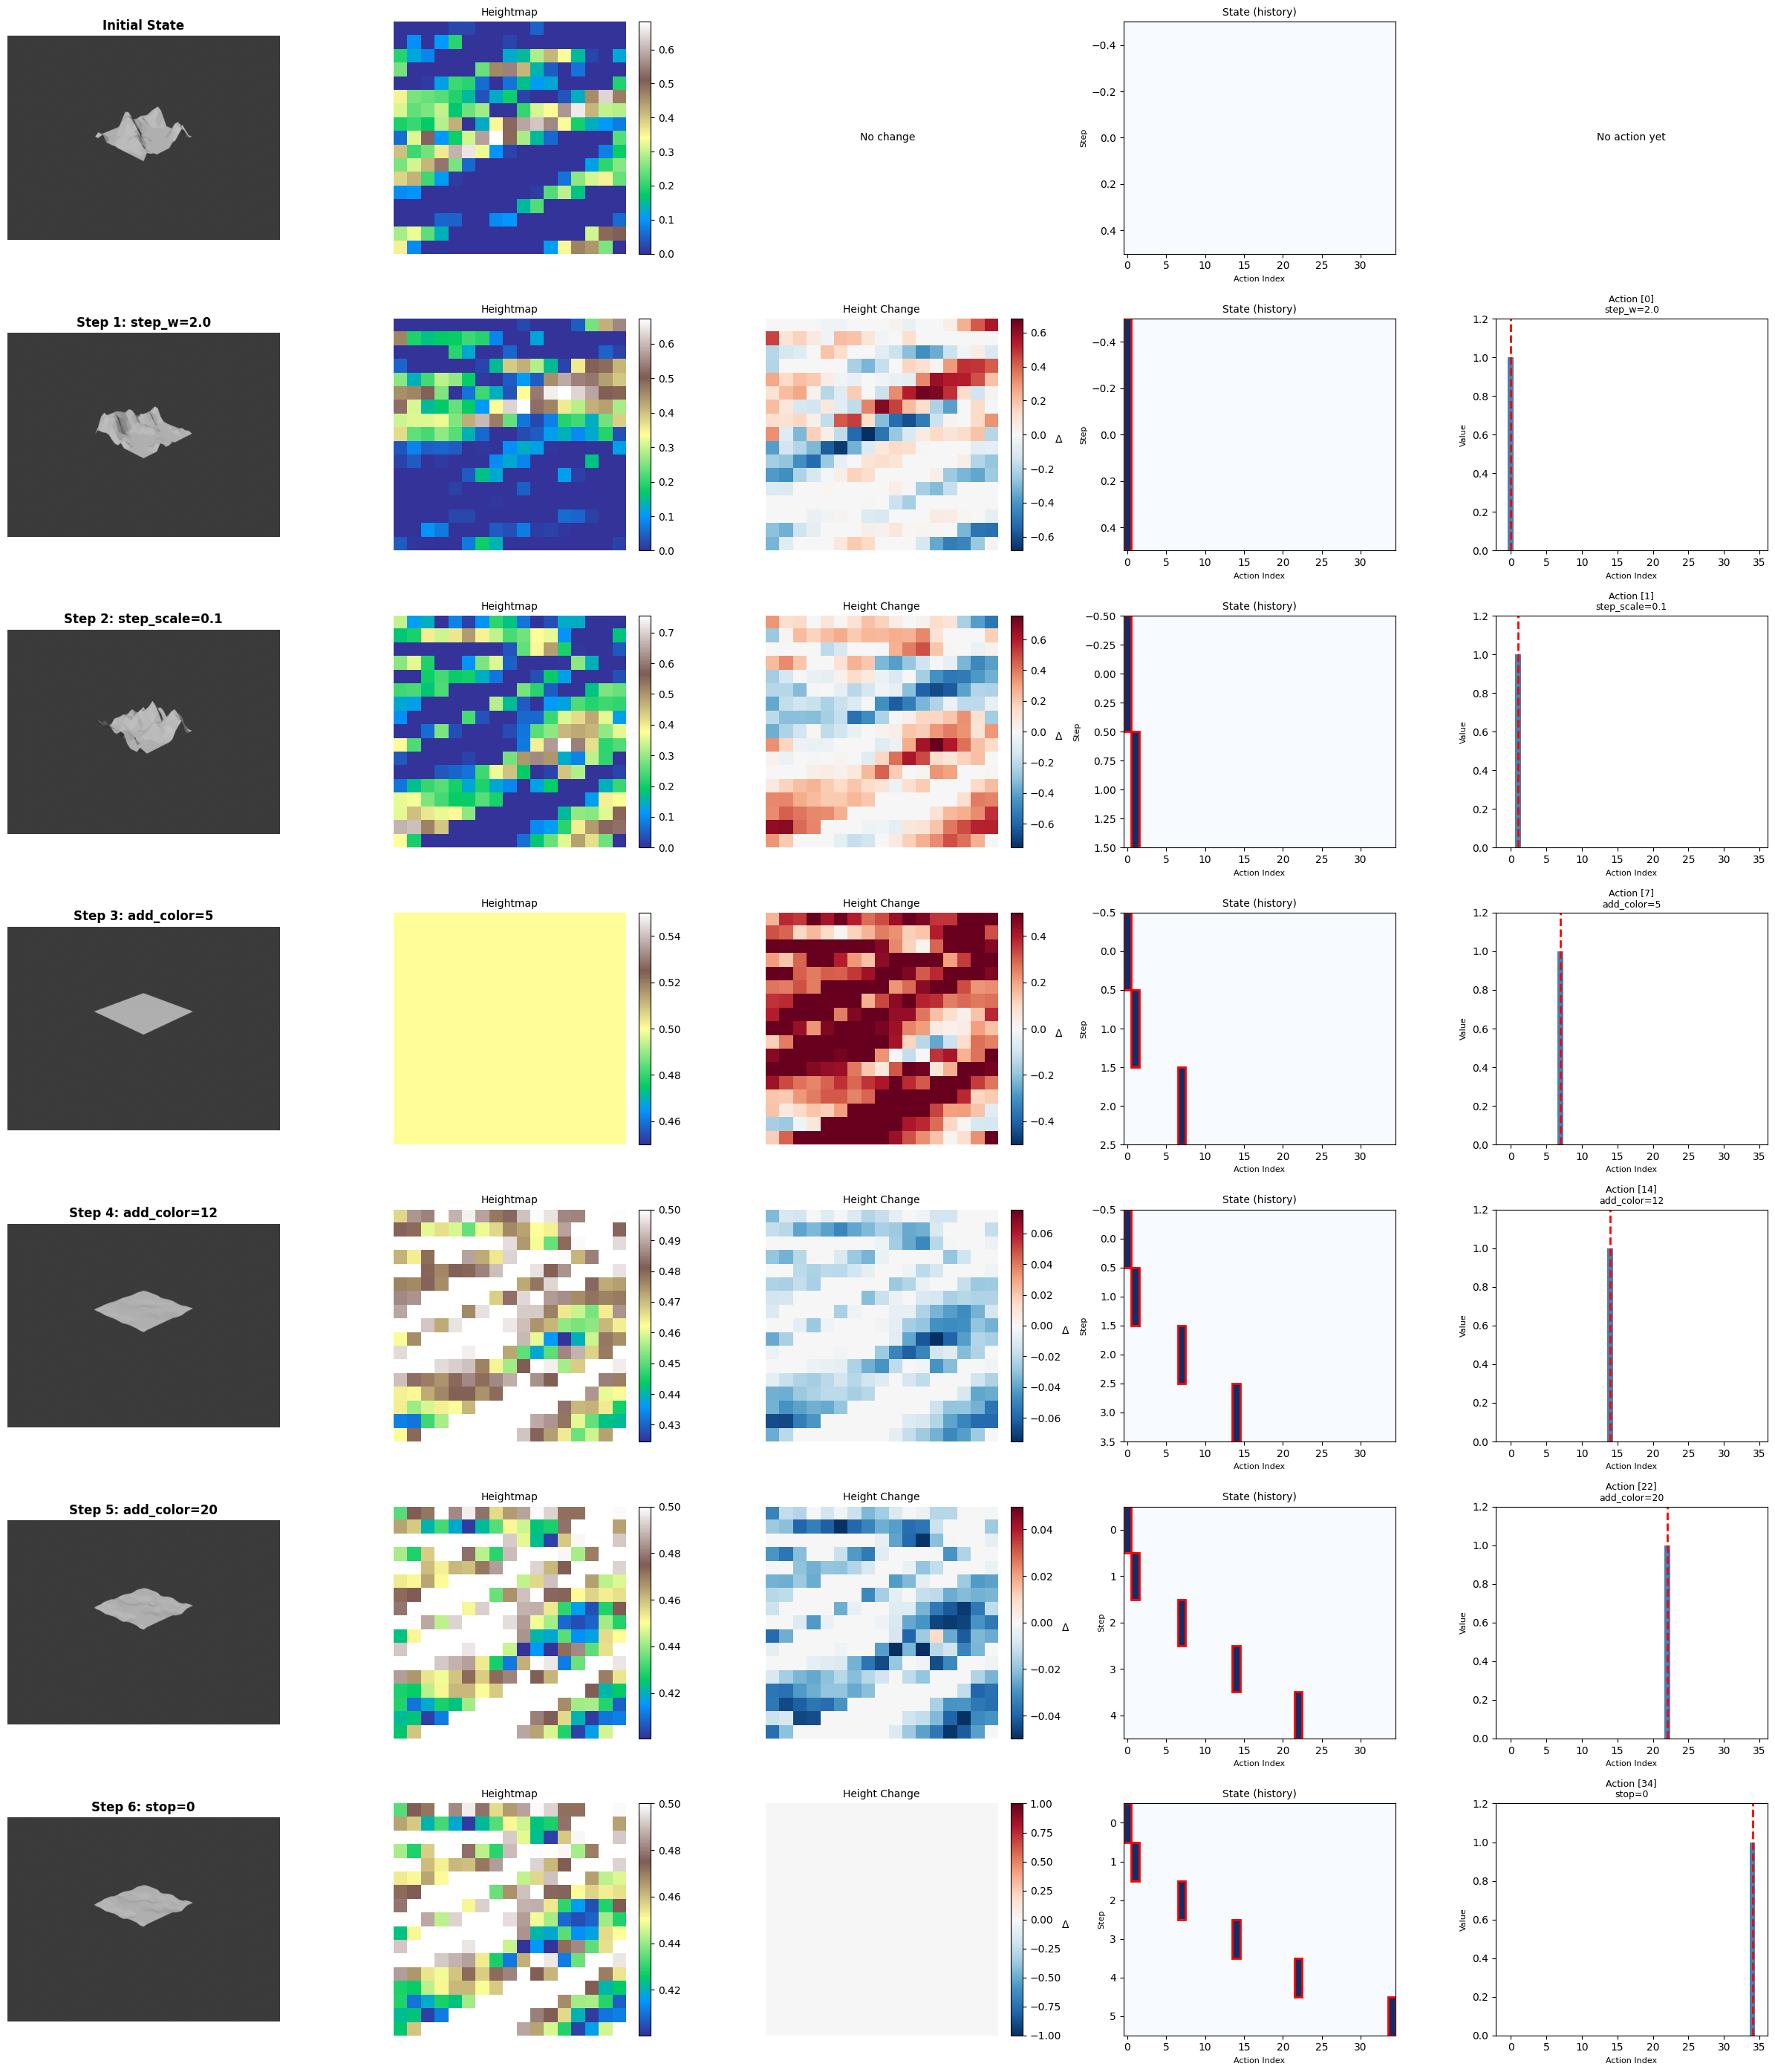


📊 Saved visualization grid to: ./tests/file_dump/trajectory_visualization.png

✅ Visualization complete!


In [3]:
def test_trajectory_with_visual_grid():
    """
    Create a visual grid showing state tensor alongside Blender screenshots and heightmaps.
    """
    from blender_setup_utils import save_blend
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from matplotlib.patches import Rectangle

    print("\n" + "=" * 80)
    print("VISUAL TRAJECTORY GRID")
    print("=" * 80)

    # Setup Blender
    load_blend_single_color_ramp()
    blender_api = BlenderTerrainAPI()

    env = v2StepWEnv()
    max_steps = 10
    action_dim = env.n_actions

    # Define actions
    actions_to_take = [
        ('step_w', 2.0),
        ('step_scale', 0.1),
        ('add_color', 5),
        ('add_color', 12),
        ('add_color', 20),
        ('stop', 0),
    ]

    # Save initial state
    screenshot_viewport_to_png(filepath="./tests/file_dump/v2_step_0_initial.png")
    heightmap = blender_api.get_heightmap()
    previous_heightmap = heightmap.clone()

    # Build state and save screenshots + heightmaps
    state = torch.zeros(max_steps, action_dim)
    screenshot_paths = ["./tests/file_dump/v2_step_0_initial.png"]
    heightmaps = [heightmap.clone()]
    color_slot_idx = 0

    for step_idx, (action_key, action_value) in enumerate(actions_to_take):
        # Convert action to one-hot
        action_one_hot = env.action_to_one_hot(action_key, action_value)
        flat_idx = torch.argmax(action_one_hot).item()
        state[step_idx] = action_one_hot

        # Execute action on Blender
        if action_key == 'add_color':
            env.execute_one_hot_action(blender_api, action_one_hot, slot_idx=color_slot_idx)
            color_slot_idx += 1
        elif action_key != 'stop':
            env.execute_one_hot_action(blender_api, action_one_hot)

        # Save screenshot and heightmap
        screenshot_path = f"./tests/file_dump/v2_step_{step_idx+1}_{action_key}.png"
        screenshot_viewport_to_png(filepath=screenshot_path)
        screenshot_paths.append(screenshot_path)

        heightmap = blender_api.get_heightmap()
        heightmaps.append(heightmap.clone())

    # Create visualization grid
    print("\nCreating visualization grid...")

    n_steps = len(actions_to_take) + 1  # +1 for initial state
    fig = plt.figure(figsize=(24, 4 * n_steps))

    for step_idx in range(n_steps):
        # Column 1: Blender screenshot
        ax_img = plt.subplot(n_steps, 5, step_idx * 5 + 1)
        img = mpimg.imread(screenshot_paths[step_idx])
        ax_img.imshow(img)
        ax_img.axis('off')

        if step_idx == 0:
            ax_img.set_title('Initial State', fontsize=12, fontweight='bold')
        else:
            action_key, action_value = actions_to_take[step_idx - 1]
            ax_img.set_title(f'Step {step_idx}: {action_key}={action_value}',
                           fontsize=12, fontweight='bold')

        # Column 2: Current Heightmap
        ax_height = plt.subplot(n_steps, 5, step_idx * 5 + 2)
        heightmap_np = heightmaps[step_idx].detach().cpu().numpy()
        im = ax_height.imshow(heightmap_np, cmap='terrain', interpolation='nearest')
        ax_height.set_title('Heightmap', fontsize=10)
        ax_height.axis('off')
        plt.colorbar(im, ax=ax_height, fraction=0.046)

        # Column 3: Heightmap Diff (from previous)
        ax_diff = plt.subplot(n_steps, 5, step_idx * 5 + 3)
        if step_idx > 0:
            prev_heightmap_np = heightmaps[step_idx - 1].detach().cpu().numpy()
            diff = heightmap_np - prev_heightmap_np
            im_diff = ax_diff.imshow(diff, cmap='RdBu_r', interpolation='nearest',
                                     vmin=-np.abs(diff).max() if np.abs(diff).max() > 0 else -1,
                                     vmax=np.abs(diff).max() if np.abs(diff).max() > 0 else 1)
            ax_diff.set_title('Height Change', fontsize=10)
            ax_diff.axis('off')
            cbar = plt.colorbar(im_diff, ax=ax_diff, fraction=0.046)
            cbar.set_label('Δ', rotation=0)
        else:
            ax_diff.text(0.5, 0.5, 'No change',
                        transform=ax_diff.transAxes,
                        ha='center', va='center', fontsize=10)
            ax_diff.axis('off')

        # Column 4: State tensor (action history up to this point)
        ax_state = plt.subplot(n_steps, 5, step_idx * 5 + 4)

        # Show state history up to this point
        state_history = state[:step_idx].clone() if step_idx > 0 else torch.zeros(1, action_dim)
        if step_idx == 0:
            state_history = torch.zeros(1, action_dim)

        # Create heatmap
        im = ax_state.imshow(state_history.numpy(), aspect='auto', cmap='Blues', vmin=0, vmax=1)
        ax_state.set_ylabel('Step', fontsize=8)
        ax_state.set_xlabel('Action Index', fontsize=8)
        ax_state.set_title(f'State (history)', fontsize=10)

        # Mark non-zero actions
        for hist_step in range(min(step_idx, max_steps)):
            action_idx = torch.argmax(state[hist_step]).item()
            if state[hist_step].sum() > 0:
                ax_state.add_patch(Rectangle((action_idx-0.5, hist_step-0.5), 1, 1,
                                            fill=False, edgecolor='red', linewidth=2))

        # Column 5: Current action (one-hot)
        ax_action = plt.subplot(n_steps, 5, step_idx * 5 + 5)

        if step_idx > 0:
            current_action = state[step_idx - 1]
            action_idx = torch.argmax(current_action).item()
            action_def = env.tensor_to_action[action_idx]

            # Show one-hot vector as bar
            ax_action.bar(range(action_dim), current_action.numpy(), color='steelblue')
            ax_action.axvline(action_idx, color='red', linewidth=2, linestyle='--')
            ax_action.set_xlabel('Action Index', fontsize=8)
            ax_action.set_ylabel('Value', fontsize=8)
            ax_action.set_title(f'Action [{action_idx}]\n{action_def.action_key}={action_def.value}',
                              fontsize=9)
            ax_action.set_ylim([0, 1.2])
        else:
            ax_action.text(0.5, 0.5, 'No action yet',
                         transform=ax_action.transAxes,
                         ha='center', va='center', fontsize=10)
            ax_action.axis('off')

    plt.tight_layout()
    plt.show()  # Display in notebook

    # Also save it
    output_path = "./tests/file_dump/trajectory_visualization.png"
    fig.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\n📊 Saved visualization grid to: {output_path}")

    print("\n" + "=" * 80)
    print("✅ Visualization complete!")
    print("=" * 80)


if __name__ == "__main__":
    test_trajectory_with_visual_grid()


VISUAL TRAJECTORY GRID
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.01 | Rendering 1 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.03 | Rendering 25 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.06 | Rendering 50 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.07 | Rendering 64 / 64 samples
Saved: 'tests/file_dump/v2_step_0_initial.png'
Time: 00:00.09 (Saving: 00:00.01)

Viewport screenshot saved to: ./tests/file_dump/v2_step_0_initial.png
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.00 | Rendering 1 / 64 samples
Fra:1 Mem:55.38M (Peak 55.38M) | Time:00:00.03 | Rendering 25 / 64 samples
Fra:1 Mem:55.38M (Peak

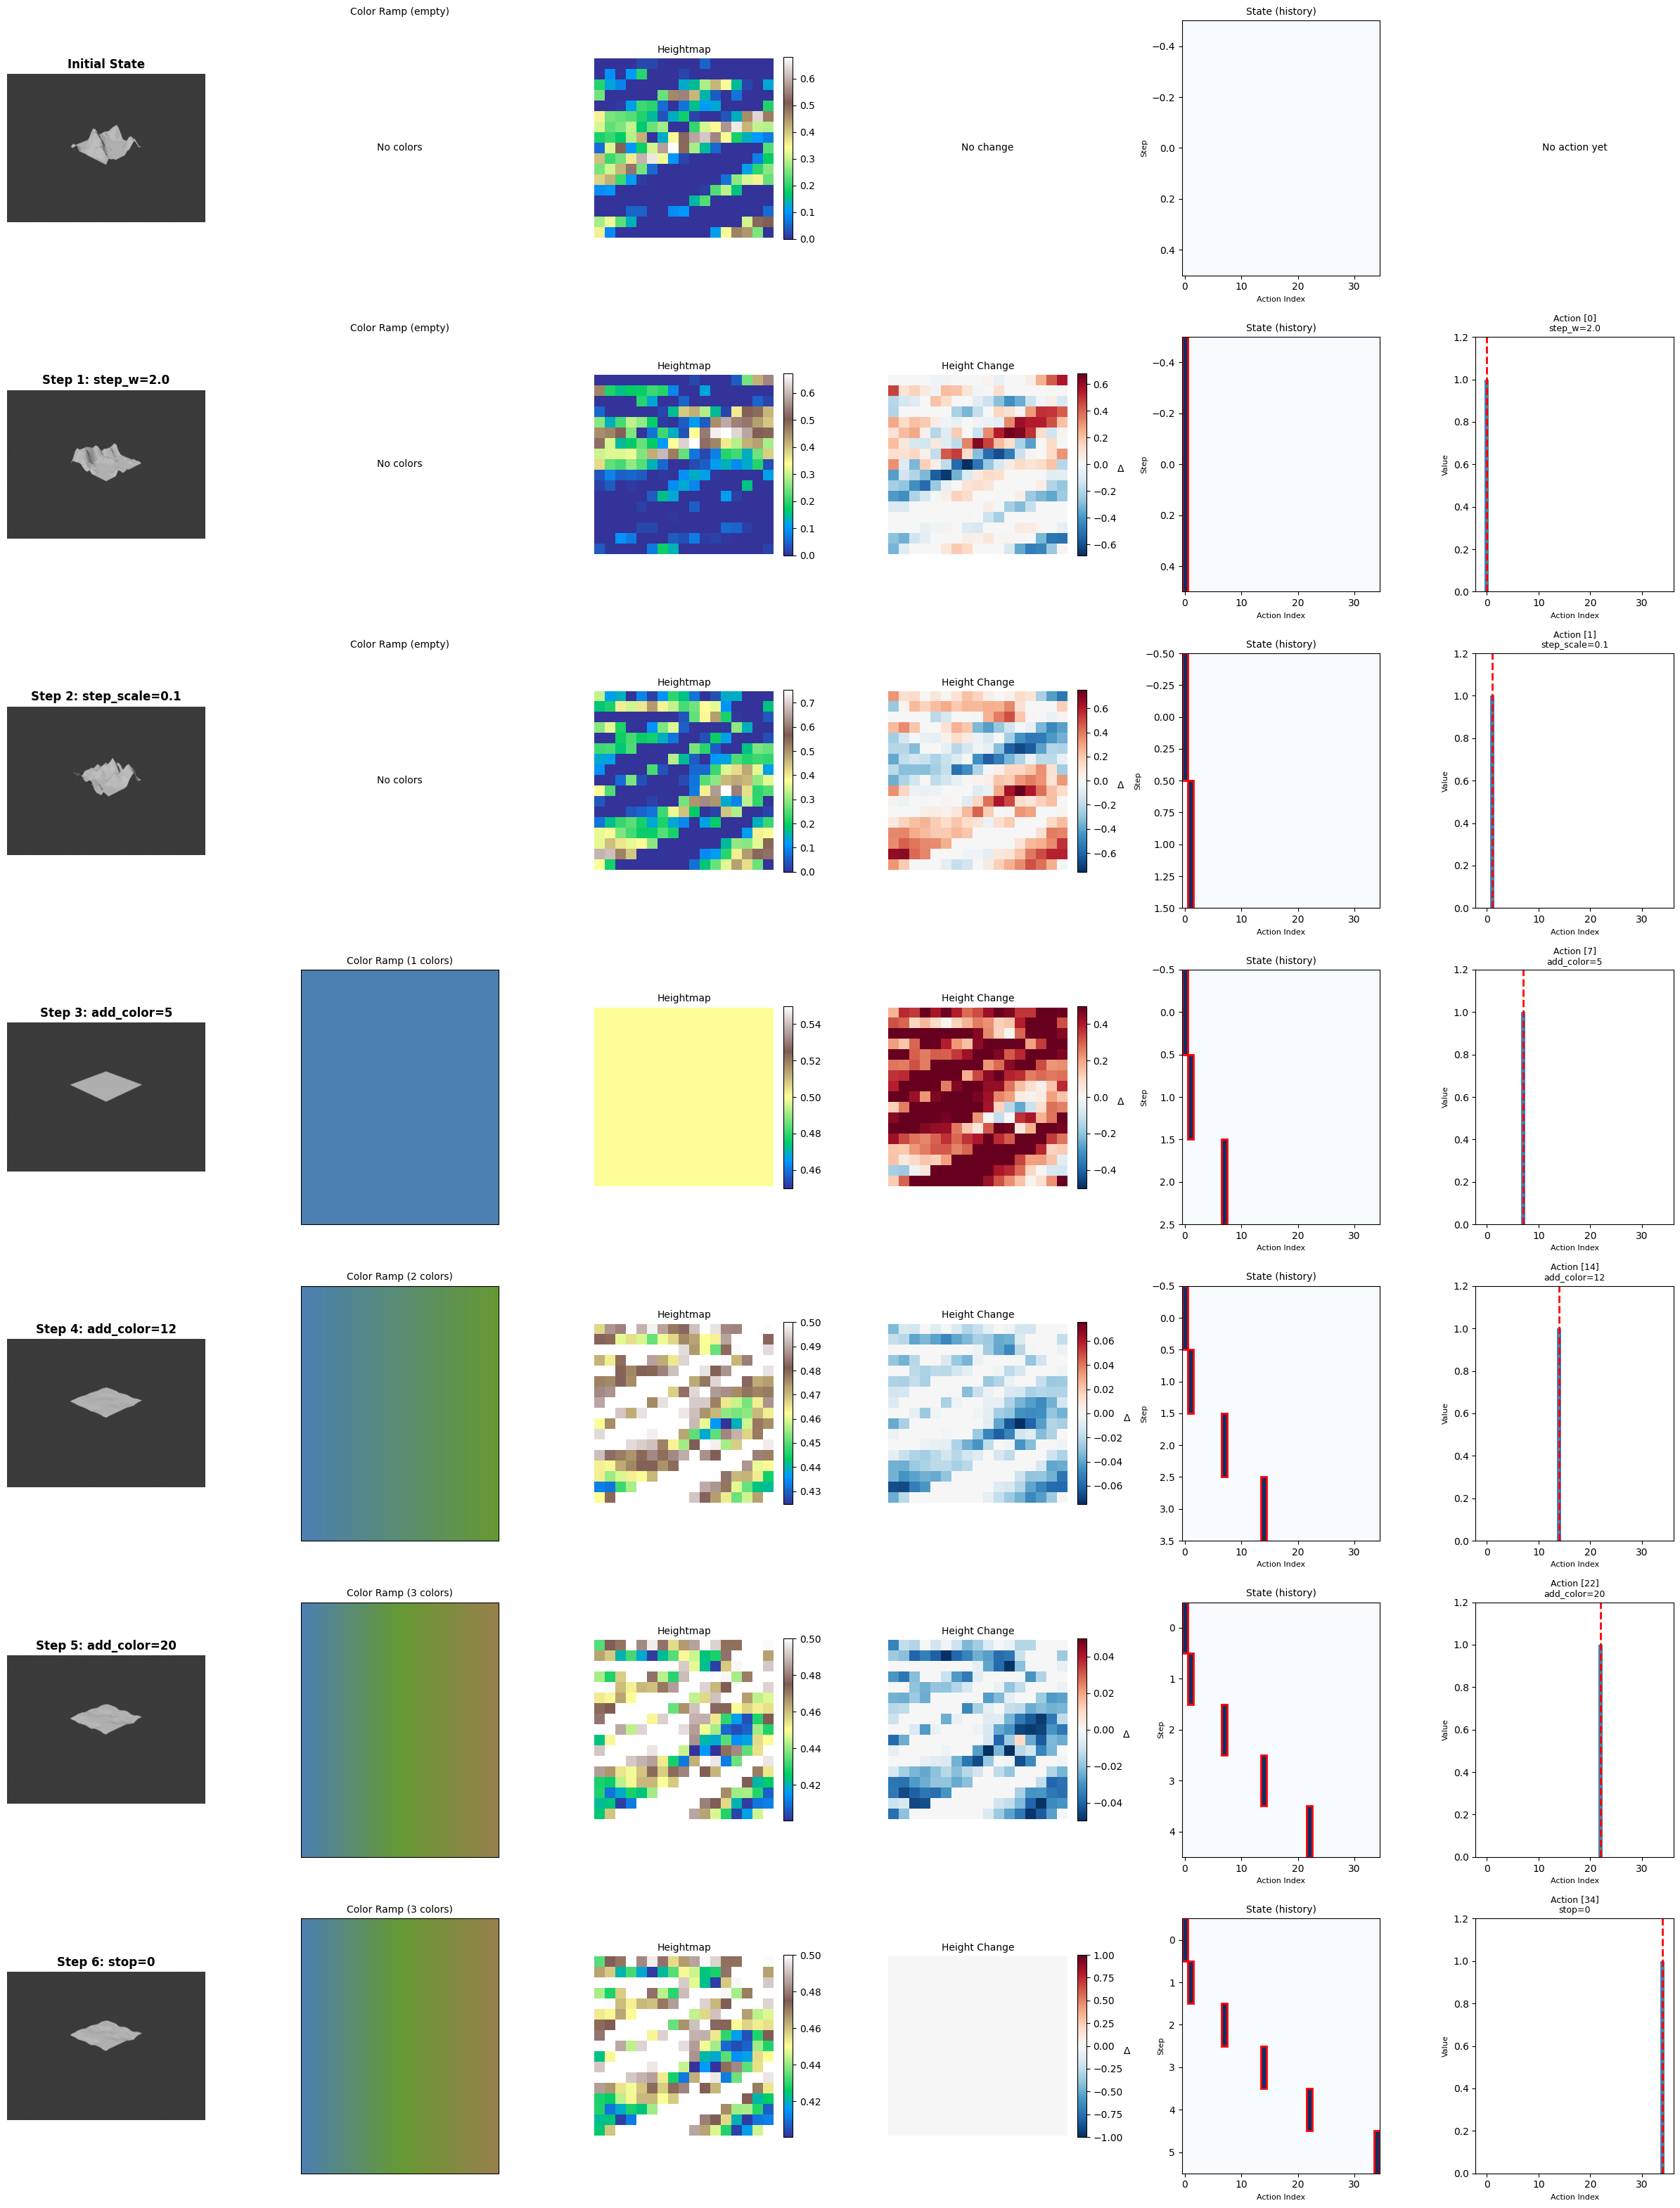


📊 Saved visualization grid to: ./tests/file_dump/trajectory_visualization.png

✅ Visualization complete!



VISUAL TRAJECTORY GRID - 20 RANDOM ACTIONS
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend
Read blend: "/home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend"
✓ Loaded template: /home/jpleona/jpleona_c/bpygfn/gfn_environments/single_color_ramp.blend

Sampling 20 random actions...
  Action 1: add_color = 24
  Action 2: step_w = 2.0
  Action 3: step_w = 2.0
  Action 4: step_scale = 0.1
  Action 5: step_scale = 0.1
  Action 6: add_color = 9
  Action 7: add_color = 11
  Action 8: add_color = 4
  Action 9: step_w = 2.0
  Action 10: add_color = 0
  Action 11: step_w = 2.0
  Action 12: step_scale = 0.1
  Action 13: step_w = 2.0
  Action 14: step_w = 2.0
  Action 15: step_scale = 0.1
  Action 16: add_color = 8
  Action 17: step_w = 2.0
  Action 18: add_color = 1
  Action 19: add_color = 16
  Action 20: add_color = 2
Fra:1 Mem:55.38M (Peak 55.38M) |

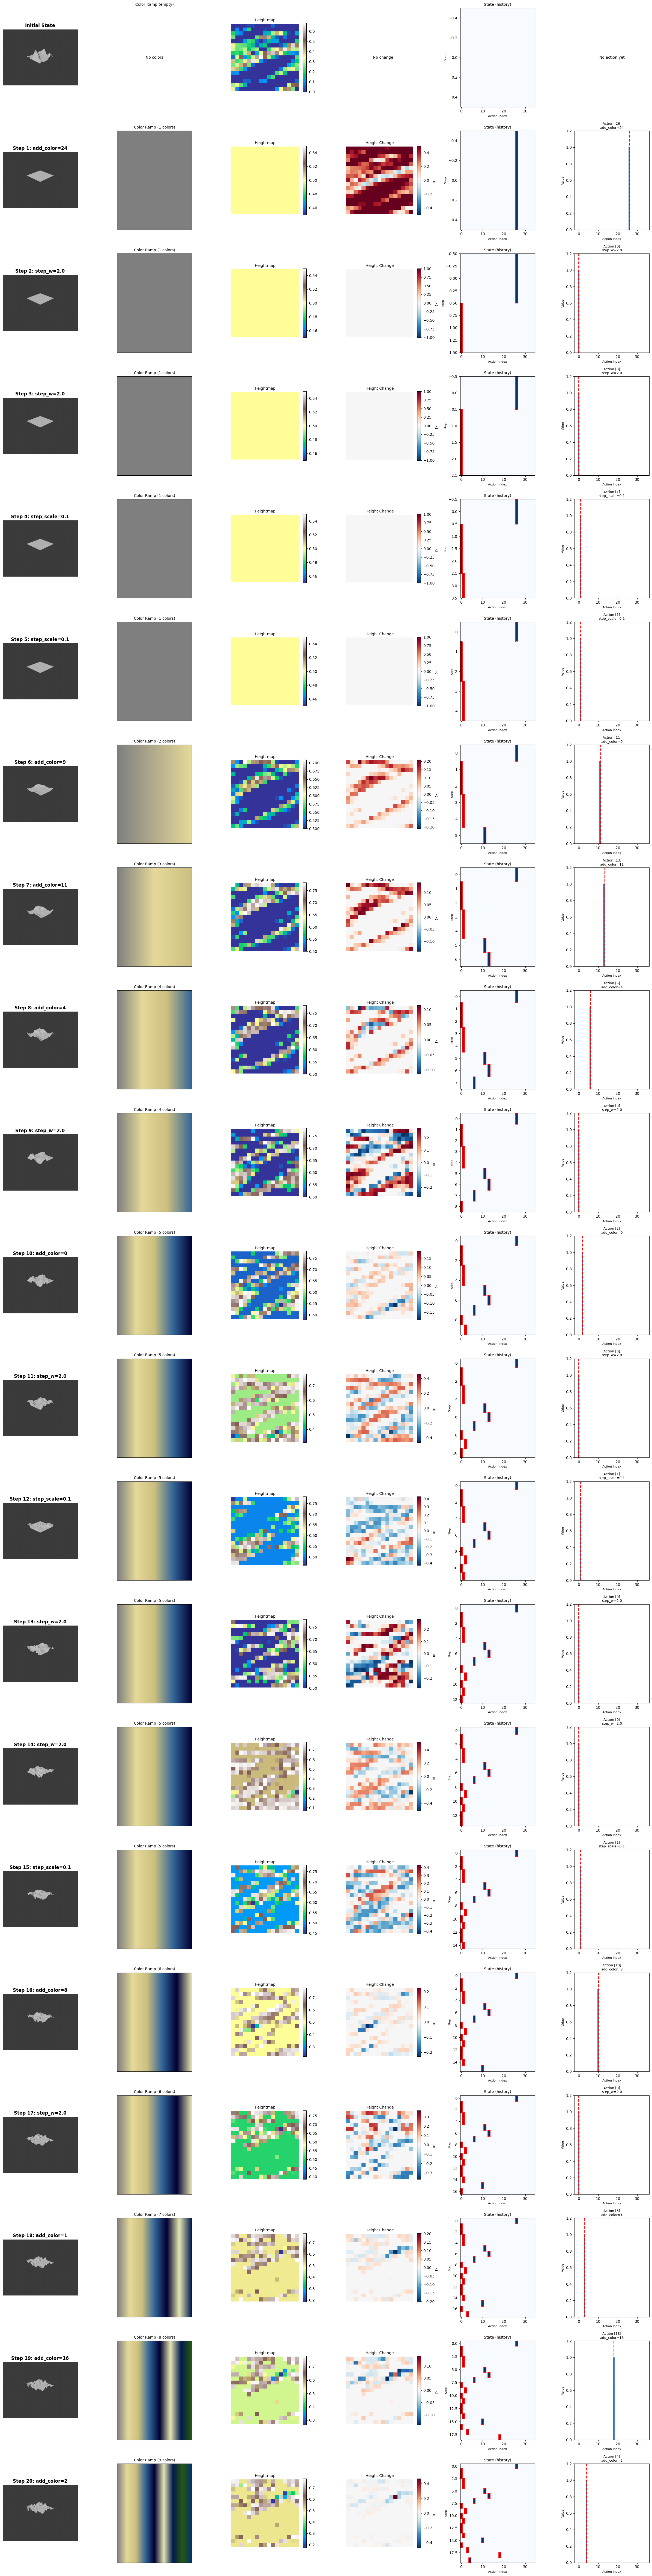


📊 Saved visualization grid to: ./tests/file_dump/trajectory_visualization_random_20.png

✅ Visualization complete!


In [7]:
def test_trajectory_with_visual_grid():
    """
    Create a visual grid showing state tensor alongside Blender screenshots and heightmaps.
    Takes 20 random actions (excluding stop).
    """
    from blender_setup_utils import save_blend
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from matplotlib.patches import Rectangle
    import numpy as np
    import random

    print("\n" + "=" * 80)
    print("VISUAL TRAJECTORY GRID - 20 RANDOM ACTIONS")
    print("=" * 80)

    # Setup Blender
    load_blend_single_color_ramp()
    blender_api = BlenderTerrainAPI()

    env = v2StepWEnv()
    max_steps = 20
    action_dim = env.n_actions

    # Sample 20 random actions (excluding stop)
    actions_to_take = []
    available_action_keys = ['step_w', 'step_scale', 'add_color']

    print("\nSampling 20 random actions...")
    for _ in range(max_steps):
        # Randomly choose action type
        action_key = random.choice(available_action_keys)

        # Get random value for that action type
        if action_key == 'step_w':
            action_value = random.choice(env.step_w_values)
        elif action_key == 'step_scale':
            action_value = random.choice(env.step_scale_values)
        elif action_key == 'add_color':
            action_value = random.randint(0, len(env.color_palette) - 1)

        actions_to_take.append((action_key, action_value))
        print(f"  Action {len(actions_to_take)}: {action_key} = {action_value}")

    # Save initial state
    screenshot_viewport_to_png(filepath="./tests/file_dump/v2_step_0_initial.png")
    heightmap = blender_api.get_heightmap()
    previous_heightmap = heightmap.clone()

    # Track color assignments over time
    color_assignment_history = [[]]  # Start with empty

    # Build state and save screenshots + heightmaps
    state = torch.zeros(max_steps, action_dim)
    screenshot_paths = ["./tests/file_dump/v2_step_0_initial.png"]
    heightmaps = [heightmap.clone()]
    color_slot_idx = 0

    for step_idx, (action_key, action_value) in enumerate(actions_to_take):
        # Convert action to one-hot
        action_one_hot = env.action_to_one_hot(action_key, action_value)
        flat_idx = torch.argmax(action_one_hot).item()
        state[step_idx] = action_one_hot

        # Execute action on Blender
        if action_key == 'add_color':
            if color_slot_idx < env.max_colors:
                env.execute_one_hot_action(blender_api, action_one_hot, slot_idx=color_slot_idx)
                color_slot_idx += 1
        elif action_key != 'stop':
            env.execute_one_hot_action(blender_api, action_one_hot)

        # Save screenshot and heightmap
        screenshot_path = f"./tests/file_dump/v2_step_{step_idx+1:02d}_{action_key}.png"
        screenshot_viewport_to_png(filepath=screenshot_path)
        screenshot_paths.append(screenshot_path)

        heightmap = blender_api.get_heightmap()
        heightmaps.append(heightmap.clone())

        # Track color assignments (reconstruct from actions taken)
        if action_key == 'add_color' and color_slot_idx <= env.max_colors:
            current_colors = color_assignment_history[-1].copy()
            current_colors.append(int(action_value))
            color_assignment_history.append(current_colors)
        else:
            color_assignment_history.append(color_assignment_history[-1].copy())

    # Create visualization grid
    print("\nCreating visualization grid...")

    n_steps = len(actions_to_take) + 1  # +1 for initial state
    fig = plt.figure(figsize=(24, 4.5 * n_steps))

    for step_idx in range(n_steps):
        # Column 1: Blender screenshot
        ax_img = plt.subplot(n_steps, 6, step_idx * 6 + 1)
        img = mpimg.imread(screenshot_paths[step_idx])
        ax_img.imshow(img)
        ax_img.axis('off')

        if step_idx == 0:
            ax_img.set_title('Initial State', fontsize=12, fontweight='bold')
        else:
            action_key, action_value = actions_to_take[step_idx - 1]
            ax_img.set_title(f'Step {step_idx}: {action_key}={action_value}',
                           fontsize=12, fontweight='bold')

        # Column 2: Color Ramp
        ax_ramp = plt.subplot(n_steps, 6, step_idx * 6 + 2)
        color_assignments = color_assignment_history[step_idx]

        if color_assignments:
            # Create a color gradient showing the ramp
            num_colors = len(color_assignments)
            colors_array = np.zeros((1, 100, 3))

            for i in range(100):
                # Interpolate position in ramp
                position = i / 99.0 * (num_colors - 1)
                lower_idx = int(np.floor(position))
                upper_idx = min(int(np.ceil(position)), num_colors - 1)
                blend = position - lower_idx

                # Get colors from palette
                lower_color = env.color_palette[color_assignments[lower_idx]]
                upper_color = env.color_palette[color_assignments[upper_idx]]

                # Blend colors (RGB only)
                colors_array[0, i] = [
                    lower_color[0] * (1 - blend) + upper_color[0] * blend,
                    lower_color[1] * (1 - blend) + upper_color[1] * blend,
                    lower_color[2] * (1 - blend) + upper_color[2] * blend
                ]

            ax_ramp.imshow(colors_array, aspect='auto')
            ax_ramp.set_title(f'Color Ramp ({len(color_assignments)} colors)', fontsize=10)
            ax_ramp.set_yticks([])
            ax_ramp.set_xticks([])
        else:
            ax_ramp.text(0.5, 0.5, 'No colors',
                        transform=ax_ramp.transAxes,
                        ha='center', va='center', fontsize=10)
            ax_ramp.set_title('Color Ramp (empty)', fontsize=10)
            ax_ramp.axis('off')

        # Column 3: Current Heightmap
        ax_height = plt.subplot(n_steps, 6, step_idx * 6 + 3)
        heightmap_np = heightmaps[step_idx].detach().cpu().numpy()
        im = ax_height.imshow(heightmap_np, cmap='terrain', interpolation='nearest')
        ax_height.set_title('Heightmap', fontsize=10)
        ax_height.axis('off')
        plt.colorbar(im, ax=ax_height, fraction=0.046)

        # Column 4: Heightmap Diff (from previous)
        ax_diff = plt.subplot(n_steps, 6, step_idx * 6 + 4)
        if step_idx > 0:
            prev_heightmap_np = heightmaps[step_idx - 1].detach().cpu().numpy()
            diff = heightmap_np - prev_heightmap_np
            max_diff = np.abs(diff).max() if np.abs(diff).max() > 0 else 1
            im_diff = ax_diff.imshow(diff, cmap='RdBu_r', interpolation='nearest',
                                     vmin=-max_diff, vmax=max_diff)
            ax_diff.set_title('Height Change', fontsize=10)
            ax_diff.axis('off')
            cbar = plt.colorbar(im_diff, ax=ax_diff, fraction=0.046)
            cbar.set_label('Δ', rotation=0)
        else:
            ax_diff.text(0.5, 0.5, 'No change',
                        transform=ax_diff.transAxes,
                        ha='center', va='center', fontsize=10)
            ax_diff.axis('off')

        # Column 5: State tensor (action history up to this point)
        ax_state = plt.subplot(n_steps, 6, step_idx * 6 + 5)

        # Show state history up to this point
        state_history = state[:step_idx].clone() if step_idx > 0 else torch.zeros(1, action_dim)
        if step_idx == 0:
            state_history = torch.zeros(1, action_dim)

        # Create heatmap
        im = ax_state.imshow(state_history.numpy(), aspect='auto', cmap='Blues', vmin=0, vmax=1)
        ax_state.set_ylabel('Step', fontsize=8)
        ax_state.set_xlabel('Action Index', fontsize=8)
        ax_state.set_title(f'State (history)', fontsize=10)

        # Mark non-zero actions
        for hist_step in range(min(step_idx, max_steps)):
            action_idx = torch.argmax(state[hist_step]).item()
            if state[hist_step].sum() > 0:
                ax_state.add_patch(Rectangle((action_idx-0.5, hist_step-0.5), 1, 1,
                                            fill=False, edgecolor='red', linewidth=2))

        # Column 6: Current action (one-hot)
        ax_action = plt.subplot(n_steps, 6, step_idx * 6 + 6)

        if step_idx > 0:
            current_action = state[step_idx - 1]
            action_idx = torch.argmax(current_action).item()
            action_def = env.tensor_to_action[action_idx]

            # Show one-hot vector as bar
            ax_action.bar(range(action_dim), current_action.numpy(), color='steelblue')
            ax_action.axvline(action_idx, color='red', linewidth=2, linestyle='--')
            ax_action.set_xlabel('Action Index', fontsize=8)
            ax_action.set_ylabel('Value', fontsize=8)
            ax_action.set_title(f'Action [{action_idx}]\n{action_def.action_key}={action_def.value}',
                              fontsize=9)
            ax_action.set_ylim([0, 1.2])
        else:
            ax_action.text(0.5, 0.5, 'No action yet',
                         transform=ax_action.transAxes,
                         ha='center', va='center', fontsize=10)
            ax_action.axis('off')

    plt.tight_layout()
    plt.show()  # Display in notebook

    # Also save it
    output_path = "./tests/file_dump/trajectory_visualization_random_20.png"
    fig.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\n📊 Saved visualization grid to: {output_path}")

    print("\n" + "=" * 80)
    print("✅ Visualization complete!")
    print("=" * 80)


if __name__ == "__main__":
    test_trajectory_with_visual_grid()